# FRED Overview

In order to programatically request data from FRED, you'll need to first request an api key from the
[FRED website](https://fred.stlouisfed.org/docs/api/api_key.html). After you have done so, you'll  have the ability to request data from FRED via python. The python package I 
have always used is [fredapi](https://github.com/mortada/fredapi). Why did I choose this package? It was the first one I chose a long time ago, it worked, and I never had a reason to change.


To do 
* show how to get unrevised data

In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
import xlwings as xw
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [14, 8]

from typing import List, Dict, Tuple, Optional, Union, Callable, Any, Iterable

## Establishing a FRED object
Step one when using FRED is to import the package and establish a master "fred" object. The fred object is the primary work horse and will be doing most of the heavy lifting. 

In [15]:
from fredapi import Fred

BRANDTS_API_KEY = "37eb22bada238c97f282715480e7d897"
fred = Fred(api_key=BRANDTS_API_KEY)

## Requesting Data

Now, let's say we would like to see the US Nominal GDP growth over time. The steps to doing this are:
1. Find the [data](https://fred.stlouisfed.org/series/GDP) on FRED (Google tends to work better than directly searching in fred)
    * My search: "fred us nominal gdp"
2. Verify this is the data you want.
3. Copy the series ID: found in the url or right after the title of the series.
4. Call the 'get_series' method on the fred object and pass the series ID as an argument:

<br>

![FRED](content_images/4_FRED/GDP_snip.PNG)


Note: There are other arugments you can pass to the 'get_series' method, such as start and end dates, but I tend to request all of the data and do any filtering I may want later. 

In [23]:
# Pull Data:
us_nominal_gdp = fred.get_series('GDP')

# For some reason, FRED returns the values in 1946 as nan, so drop those:
us_nominal_gdp = us_nominal_gdp.dropna()

# Also, I think the data prints prettier in the notebook if it is converted to a DataFrame:
us_nominal_gdp = pd.DataFrame(data=us_nominal_gdp, columns=['GDP'])
us_nominal_gdp

,GDP
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
...,...
2022-07-01,25994.639
2022-10-01,26408.405
2023-01-01,26813.601
2023-04-01,27063.012


That's basically all there is to it!

## Helpful Functions

There are a few tasks that I tend to do frequently when working with FRED data and some enhancements I like on top of the data initially returned from the api. Because of that, I have a few helper functions that I use as a wrapper around the api that I primarily interact with. Some of these tasks are:  
* Converting from series to a dataframe. 
* Providing a better name for the data, rather than the FRED series id. 
* Send in an iterable of ids to request the data in bulk.
* Merge the data together

In [34]:
def get_fred_data_series(series_id: str, name: Optional[str] = None) -> pd.DataFrame:
    '''This function pulls data from FRED and returns it as a DataFrame, if you input a name, it will use that as the
      column name, otherwise it will use the series_id as the column name. '''
    
    data_name = name if name is not None else series_id
    df = fred.get_series(series_id).to_frame()
    df.columns = [data_name]
    df.index.name = "date"
    return df

def get_fred_data(series_ids: Union[List[str],str], names: Optional[Union[List[str],str]] = None,merge_data:bool=True) -> Union[pd.DataFrame,dict]:

    # If the input was a string, we can just call the get_fred_data_series function once right now and return the result
    if isinstance(series_ids, str):
        return get_fred_data_series(series_ids, names)
    

    names = names if names is not None else series_ids
    ids_and_names = zip(series_ids, names)
    # Now pull the data
    all_data = [get_fred_data_series(series_id, name) for series_id, name in ids_and_names]

    if merge_data:
        result = pd.concat(all_data, axis=1)
    else:
        result = dict(zip(series_ids,all_data))

    return result


Test out the function. 

One dataset:

In [36]:
get_fred_data('GDP').tail()

,GDP
date,
2022-07-01,25994.639
2022-10-01,26408.405
2023-01-01,26813.601
2023-04-01,27063.012
2023-07-01,27623.543


Multiple Series, that we want to combine - GDP & Real GDP:

In [37]:
DATA_TO_REQUEST = ['GDP','GDPC1']
DATA_NAMES = ['GDP','Real GDP']
gdp_df = get_fred_data(DATA_TO_REQUEST, DATA_NAMES)
gdp_df.tail()

,GDP,Real GDP
date,,
2022-07-01,25994.639,21851.134
2022-10-01,26408.405,21989.981
2023-01-01,26813.601,22112.329
2023-04-01,27063.012,22225.350
2023-07-01,27623.543,22491.567


Beautiful, now test how it looks if we don't want to combine the data. 

In [40]:

DATA_TO_REQUEST = ['GDP','GDPC1','CPIAUCSL']
DATA_NAMES = ['GDP','Real GDP','cpi']
data_dict = get_fred_data(DATA_TO_REQUEST, DATA_NAMES,merge_data=False)
# Show me the inflation data:
data_dict['CPIAUCSL']

,cpi
date,
1947-01-01,21.480
1947-02-01,21.620
1947-03-01,22.000
1947-04-01,22.000
1947-05-01,21.950
...,...
2023-06-01,303.841
2023-07-01,304.348
2023-08-01,306.269


## Examples

### GDP Growth
Let's look at the growth of both nominal and real gdp in the US.
* Why do people annualize by multiplying by 4 instead for raising to fourth power. I have no idea. I think it is just convention. 

In [42]:
# Request the data and verify that it looks ok:
DATA_TO_REQUEST = ['GDP','GDPC1']
DATA_NAMES = ['GDP','Real_GDP']
gdp_df = get_fred_data(DATA_TO_REQUEST, DATA_NAMES)

# Calculate the Quarterly Growth Rate:
gdp_df['Real_GDP_Growth_Q'] = gdp_df['Real_GDP'].pct_change(periods=1)
gdp_df['Nominal_GDP_Growth_Q'] = gdp_df['GDP'].pct_change(periods=1)

# Calculate the Annualized Growth Rate:
gdp_df['Real_GDP_Growth_Annualized'] = gdp_df['Real_GDP_Growth_Q'] * 4
gdp_df['Nominal_GDP_Growth_Annualized'] = gdp_df['Nominal_GDP_Growth_Q'] * 4

# Drop NaNs that were introducted by the pct_change function (We also need to drop those NANs from 1926.) 
gdp_df = gdp_df.dropna()

gdp_df.tail()

,GDP,Real_GDP,Real_GDP_Growth_Q,Nominal_GDP_Growth_Q,Real_GDP_Growth_Annualized,Nominal_GDP_Growth_Annualized
date,,,,,,
2022-07-01,25994.639,21851.134,0.006586,0.017631,0.026345,0.070523
2022-10-01,26408.405,21989.981,0.006354,0.015917,0.025417,0.063669
2023-01-01,26813.601,22112.329,0.005564,0.015343,0.022255,0.061374
2023-04-01,27063.012,22225.350,0.005111,0.009302,0.020445,0.037207
2023-07-01,27623.543,22491.567,0.011978,0.020712,0.047912,0.082848


C:\Users\User\AppData\Local\Temp\ipykernel_12916\2846428898.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])


''

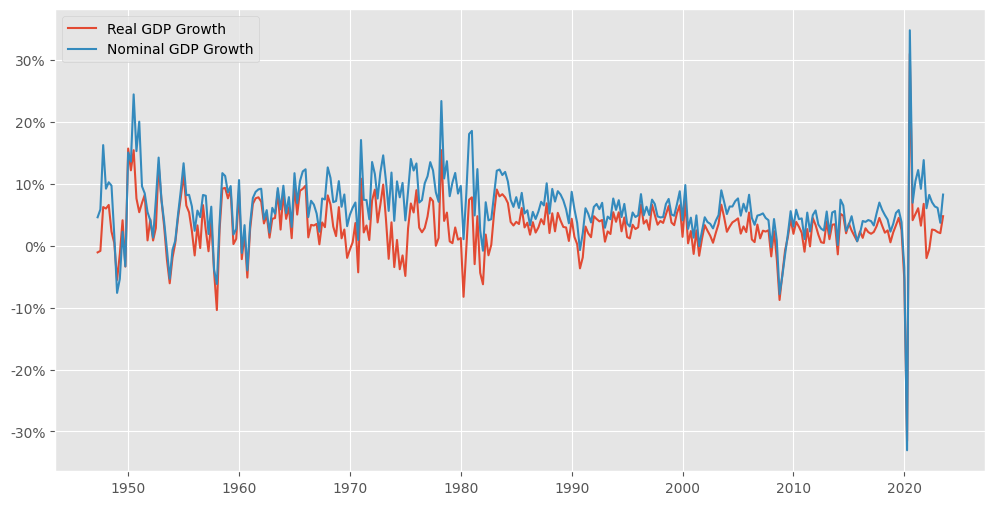

In [51]:
# Plot the data:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(gdp_df['Real_GDP_Growth_Annualized'], label='Real GDP Growth')
ax.plot(gdp_df['Nominal_GDP_Growth_Annualized'], label='Nominal GDP Growth')
# ax.plot(gdp_df['Real_GDP'], label='Real GDP')
# ax.plot(gdp_df['GDP'], label='Nominal GDP')
# Format the y axis as a percent:
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.legend()
;

### Inflation

In [52]:
INFLATION_SERIES = 'CPIAUCSL'
inflation_df = get_fred_data(INFLATION_SERIES)
# Month over month change
inflation_df['Inflation_MoM'] = inflation_df['CPIAUCSL'].pct_change(periods=1)
# YoY change
inflation_df['Inflation_YoY'] = inflation_df['CPIAUCSL'].pct_change(periods=12)

# Drop nas:
inflation_df = inflation_df.dropna()
inflation_df

,CPIAUCSL,Inflation_MoM,Inflation_YoY
date,,,
1948-01-01,23.680,0.011534,0.102421
1948-02-01,23.670,-0.000422,0.094820
1948-03-01,23.500,-0.007182,0.068182
1948-04-01,23.820,0.013617,0.082727
1948-05-01,24.010,0.007976,0.093850
...,...,...,...
2023-06-01,303.841,0.001804,0.030920
2023-07-01,304.348,0.001669,0.032991
2023-08-01,306.269,0.006312,0.037075


C:\Users\User\AppData\Local\Temp\ipykernel_12916\2205478150.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])


''

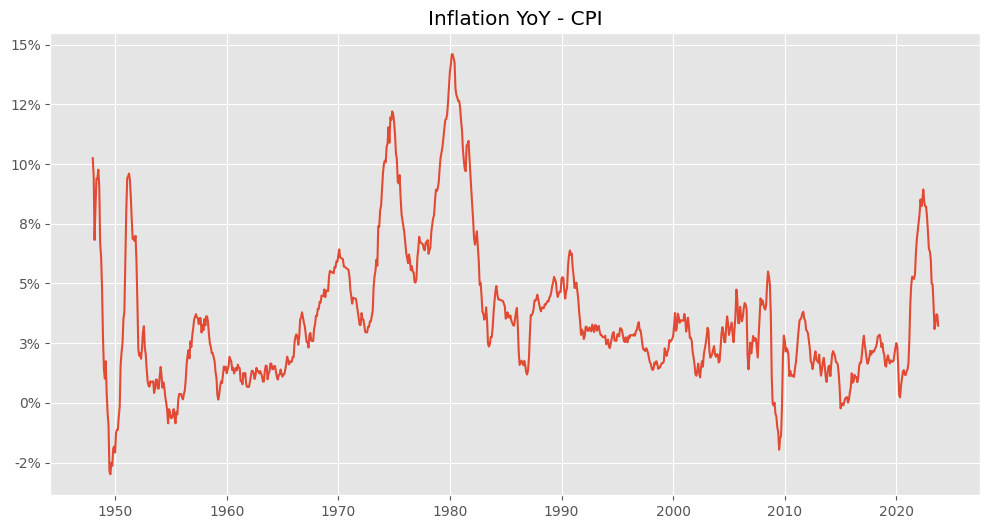

In [58]:
fig, ax = plt.subplots(figsize=(12,6))
# ax.plot(inflation_df['Inflation_MoM'], label='Inflation MoM')
ax.plot(inflation_df['Inflation_YoY'], label='Inflation YoY')
# Format the y axis as a percent:
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.set_title('Inflation YoY - CPI')
;

### VIX

In [ ]:
VIX_SERIES = 'VIXCLS'